
Evaluating Ordinal Encoding:
Ridge (Ordinal) - RMSE: 30.2764, AUC: 0.9900
Confusion Matrix:
[[9 1]
 [1 9]]
Lasso (Ordinal) - RMSE: 34.5351, AUC: 1.0000
Confusion Matrix:
[[10  0]
 [ 0 10]]
Decision Tree (Ordinal) - RMSE: 48.7679, AUC: 0.9150
Confusion Matrix:
[[9 1]
 [1 9]]
Splines (Ordinal) - RMSE: 52.3749, AUC: 0.8900
Confusion Matrix:
[[8 2]
 [2 8]]
Best model for Ordinal Encoding: Ridge with RMSE: 30.2764



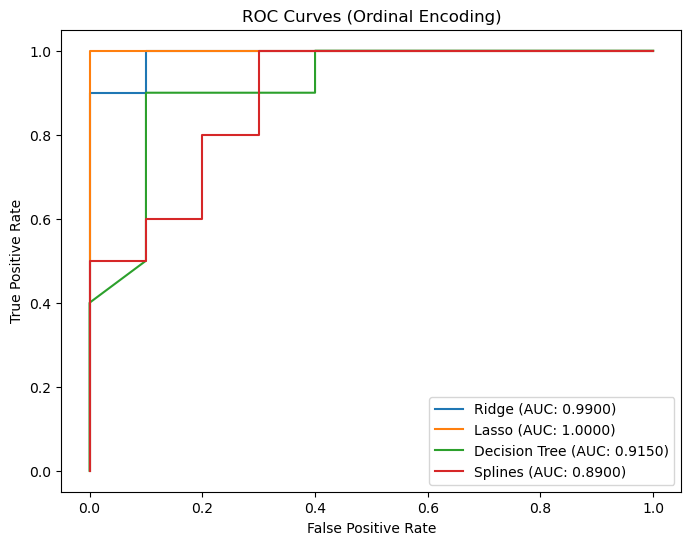

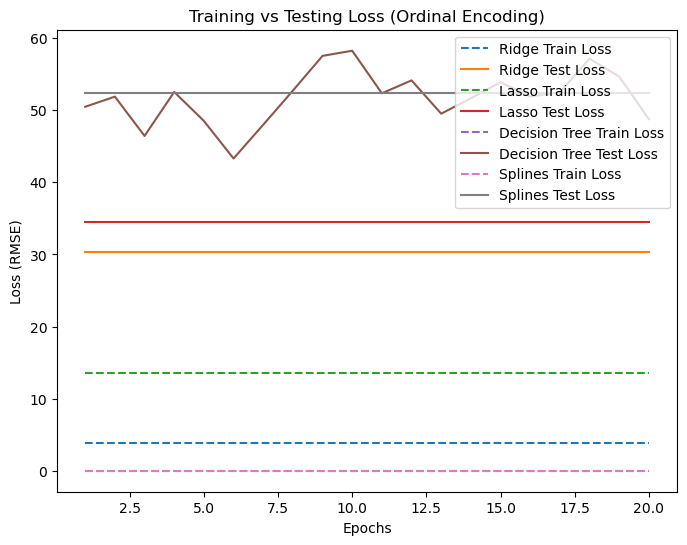


Evaluating One-Hot Encoding:
Ridge (One-Hot) - RMSE: 37.5690, AUC: 0.9800
Confusion Matrix:
[[9 1]
 [1 9]]
Lasso (One-Hot) - RMSE: 35.6655, AUC: 1.0000
Confusion Matrix:
[[10  0]
 [ 0 10]]
Decision Tree (One-Hot) - RMSE: 53.8517, AUC: 0.8700
Confusion Matrix:
[[8 2]
 [3 7]]
Splines (One-Hot) - RMSE: 50.5812, AUC: 0.9000
Confusion Matrix:
[[8 2]
 [2 8]]
Best model for One-Hot Encoding: Lasso with RMSE: 35.6655



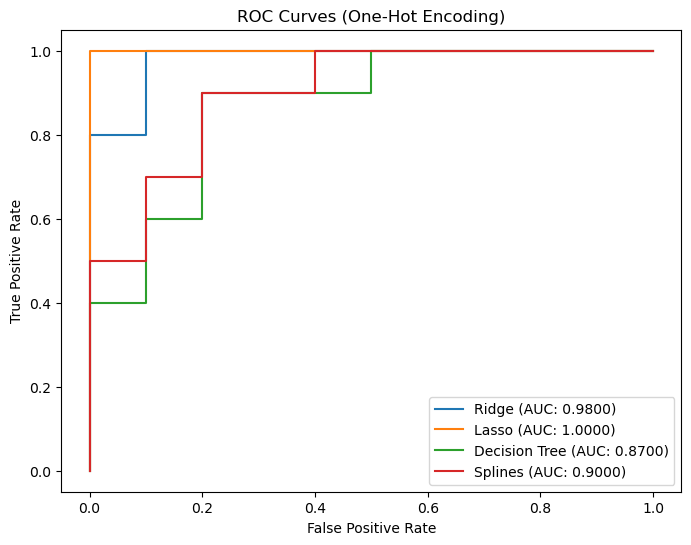

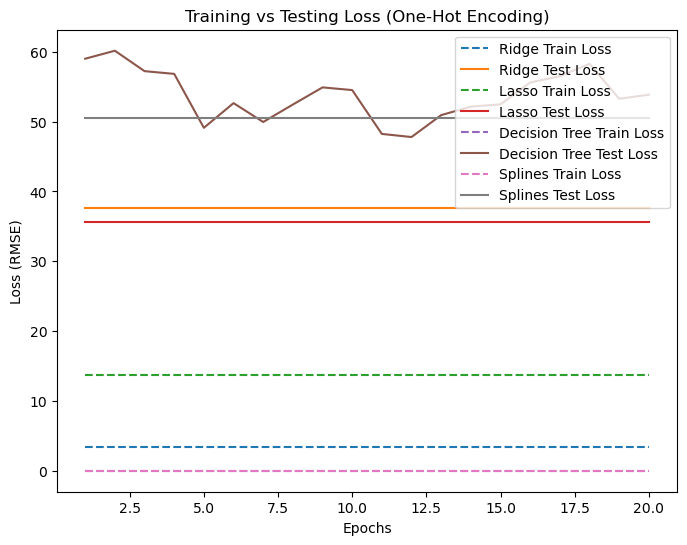

Overall Best Model: Ridge using Ordinal Encoding


In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, SplineTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, roc_curve

# Load the datasets
data = pd.read_csv(r"C:\Users\snehi\Documents\CDA_Assignments\case1Data.csv")
xnew = pd.read_csv(r"C:\Users\snehi\Documents\CDA_Assignments\case1Data_Xnew.csv")

# Identify categorical and numerical columns
categorical_cols = ['C_01', 'C_02', 'C_03', 'C_04', 'C_05']
numerical_cols = [col for col in data.columns if col not in categorical_cols + ['y']]

# Handle missing values for numerical data
num_imputer = SimpleImputer(strategy='mean')
data[numerical_cols] = num_imputer.fit_transform(data[numerical_cols])
xnew[numerical_cols] = num_imputer.transform(xnew[numerical_cols])

# Treat missing categorical values as a new category "Missing"
data[categorical_cols] = data[categorical_cols].astype(str).fillna("Missing")
xnew[categorical_cols] = xnew[categorical_cols].astype(str).fillna("Missing")

# Encoding
ordinal_encoder = OrdinalEncoder()
data_ordinal = data.copy()
data_ordinal[categorical_cols] = ordinal_encoder.fit_transform(data_ordinal[categorical_cols])
xnew_ordinal = xnew.copy()
xnew_ordinal[categorical_cols] = ordinal_encoder.transform(xnew_ordinal[categorical_cols])

encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
data_onehot = data.copy()
xnew_onehot = xnew.copy()
data_onehot_encoded = encoder.fit_transform(data_onehot[categorical_cols])
xnew_onehot_encoded = encoder.transform(xnew_onehot[categorical_cols])
data_onehot = data_onehot.drop(columns=categorical_cols).reset_index(drop=True)
xnew_onehot = xnew_onehot.drop(columns=categorical_cols).reset_index(drop=True)
data_onehot = pd.concat([data_onehot, pd.DataFrame(data_onehot_encoded, columns=encoder.get_feature_names_out(categorical_cols))], axis=1)
xnew_onehot = pd.concat([xnew_onehot, pd.DataFrame(xnew_onehot_encoded, columns=encoder.get_feature_names_out(categorical_cols))], axis=1)

# Standardize numerical features
scaler = StandardScaler()
data_ordinal[numerical_cols] = scaler.fit_transform(data_ordinal[numerical_cols])
data_onehot[numerical_cols] = scaler.transform(data_onehot[numerical_cols])
xnew_ordinal[numerical_cols] = scaler.transform(xnew_ordinal[numerical_cols])
xnew_onehot[numerical_cols] = scaler.transform(xnew_onehot[numerical_cols])

# Split data
X_ord, X_test_ord, y_ord, y_test_ord = train_test_split(data_ordinal.drop(columns=['y']), data_ordinal['y'], test_size=0.2, random_state=42)
X_oh, X_test_oh, y_oh, y_test_oh = train_test_split(data_onehot.drop(columns=['y']), data_onehot['y'], test_size=0.2, random_state=42)

# Models
models = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Splines": make_pipeline(SplineTransformer(n_knots=5, degree=3), LinearRegression())
}

def evaluate_models(X_train, X_test, y_train, y_test, encoding_type):
    results = {}
    loss_plot_data = {}
    roc_data = {}
    print(f"\nEvaluating {encoding_type} Encoding:")
    
    for name, model in models.items():
        train_losses = []
        test_losses = []
        
        for epoch in range(1, 21):
            model.fit(X_train, y_train)
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            train_loss = np.sqrt(mean_squared_error(y_train, y_train_pred))
            test_loss = np.sqrt(mean_squared_error(y_test, y_test_pred))
            train_losses.append(train_loss)
            test_losses.append(test_loss)
        
        loss_plot_data[name] = (train_losses, test_losses)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        auc = roc_auc_score((y_test > np.median(y_test)).astype(int), y_pred)
        fpr, tpr, _ = roc_curve((y_test > np.median(y_test)).astype(int), y_pred)
        roc_data[name] = (fpr, tpr, auc)
        
        cm = confusion_matrix((y_test > np.median(y_test)).astype(int), (y_pred > np.median(y_pred)).astype(int))
        print(f"{name} ({encoding_type}) - RMSE: {rmse:.4f}, AUC: {auc:.4f}")
        print("Confusion Matrix:")
        print(cm)
        results[name] = rmse
    
    best_model = min(results, key=results.get)
    print(f"Best model for {encoding_type} Encoding: {best_model} with RMSE: {results[best_model]:.4f}\n")
    
    plt.figure(figsize=(8, 6))
    for name, (fpr, tpr, auc) in roc_data.items():
        plt.plot(fpr, tpr, label=f'{name} (AUC: {auc:.4f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves ({encoding_type} Encoding)')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(8, 6))
    for name, (train_losses, test_losses) in loss_plot_data.items():
        plt.plot(range(1, 21), train_losses, linestyle='dashed', label=f'{name} Train Loss')
        plt.plot(range(1, 21), test_losses, label=f'{name} Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (RMSE)')
    plt.title(f'Training vs Testing Loss ({encoding_type} Encoding)')
    plt.legend()
    plt.show()
    
    return results, best_model

# Evaluate models
results_ordinal, best_model_ord = evaluate_models(X_ord, X_test_ord, y_ord, y_test_ord, "Ordinal")
results_onehot, best_model_oh = evaluate_models(X_oh, X_test_oh, y_oh, y_test_oh, "One-Hot")

# Select overall best model
best_encoding = "Ordinal" if results_ordinal[best_model_ord] < results_onehot[best_model_oh] else "One-Hot"
best_model = best_model_ord if best_encoding == "Ordinal" else best_model_oh
print(f"Overall Best Model: {best_model} using {best_encoding} Encoding")

# Save results
np.savetxt("predictions_YourStudentNos.csv", ynew_pred, delimiter=",")
np.savetxt("estimatedRMSE_YourStudentNos.csv", [rmse_estimate], delimiter=",")

In [1]:
#25 March 2025

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, SplineTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# Load the datasets
data = pd.read_csv("case1Data.csv")
xnew = pd.read_csv("case1Data_Xnew.csv")

# Identify categorical and numerical columns
categorical_cols = ['C_01', 'C_02', 'C_03', 'C_04', 'C_05']
numerical_cols = [col for col in data.columns if col not in categorical_cols + ['y']]

# Handle missing values for numerical data
num_imputer = SimpleImputer(strategy='mean')
data[numerical_cols] = num_imputer.fit_transform(data[numerical_cols])
xnew[numerical_cols] = num_imputer.transform(xnew[numerical_cols])

# Treat missing categorical values as a new category "Missing"
data[categorical_cols] = data[categorical_cols].fillna("Missing").astype(str)
xnew[categorical_cols] = xnew[categorical_cols].fillna("Missing").astype(str)

# One-Hot Encoding
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
data_encoded = encoder.fit_transform(data[categorical_cols])
xnew_encoded = encoder.transform(xnew[categorical_cols])

# Drop original categorical columns and concatenate encoded features
data = data.drop(columns=categorical_cols).reset_index(drop=True)
xnew = xnew.drop(columns=categorical_cols).reset_index(drop=True)
data = pd.concat([data, pd.DataFrame(data_encoded, columns=encoder.get_feature_names_out(categorical_cols))], axis=1)
xnew = pd.concat([xnew, pd.DataFrame(xnew_encoded, columns=encoder.get_feature_names_out(categorical_cols))], axis=1)

# Standardize numerical features
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
xnew[numerical_cols] = scaler.transform(xnew[numerical_cols])

# Train/test split
X = data.drop(columns=['y'])
y = data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Splines": make_pipeline(SplineTransformer(n_knots=5, degree=3), LinearRegression())
}

# Evaluate models using RMSE
def evaluate_models(X_train, X_test, y_train, y_test):
    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"{name} - RMSE: {rmse:.4f}")
        results[name] = (rmse, model)

    best_model_name = min(results, key=lambda k: results[k][0])
    best_rmse, best_model = results[best_model_name]
    print(f"\nBest model: {best_model_name} with RMSE: {best_rmse:.4f}")
    
    return best_model, best_model_name, best_rmse

best_model, best_model_name, best_rmse = evaluate_models(X_train, X_test, y_train, y_test)

# Estimate RMSE using cross-validation
cv_rmse = -cross_val_score(best_model, X, y, scoring='neg_root_mean_squared_error', cv=5).mean()
print(f"Estimated RMSE (CrossVal): {cv_rmse:.4f}")

# Train on full data and predict for xnew
best_model.fit(X, y)
ynew_pred = best_model.predict(xnew)

# Save outputs (adjust your student number in filenames)
np.savetxt("predictions_YourStudentNos.csv", ynew_pred, delimiter=",")
np.savetxt("estimatedRMSE_YourStudentNos.csv", [cv_rmse], delimiter=",")


Ridge - RMSE: 37.5690
Lasso - RMSE: 35.6655
Decision Tree - RMSE: 51.7549
Splines - RMSE: 50.5812

Best model: Lasso with RMSE: 35.6655
Estimated RMSE (CV): 31.2615



 Comparing Numerical Feature Distributions (Train vs Xnew)


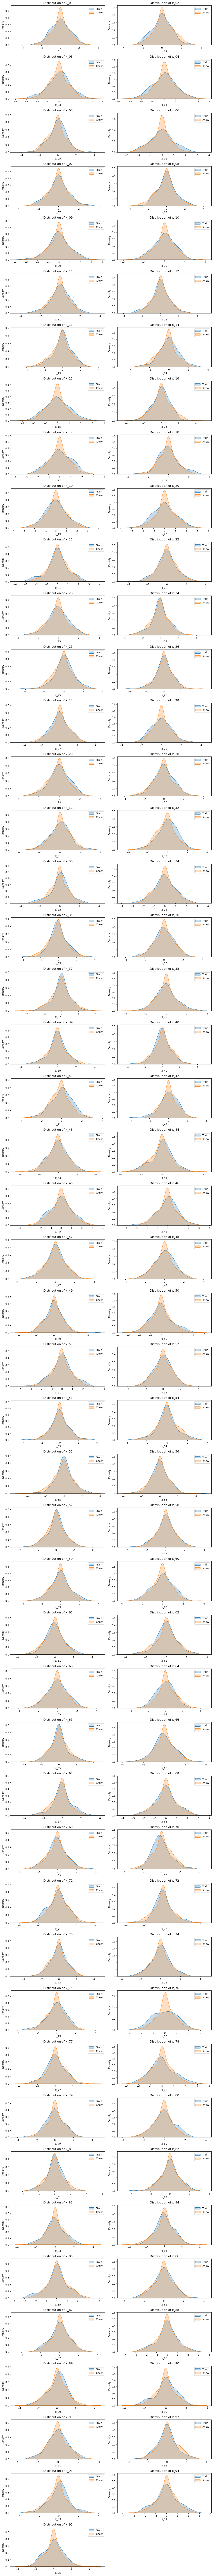

In [5]:
import math
import matplotlib.pyplot as plt
import seaborn as sns

print("\n Comparing Numerical Feature Distributions (Train vs Xnew)")

# Number of features
n_features = len(numerical_cols)
n_cols = 2
n_rows = math.ceil(n_features / n_cols)

# Create subplots grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows))
axes = axes.flatten()  # Flatten to make indexing easier

# Plot each feature
for i, col in enumerate(numerical_cols):
    sns.kdeplot(data[col], label='Train', fill=True, ax=axes[i])
    sns.kdeplot(xnew[col], label='Xnew', fill=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].legend()

# Remove unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
